<a href="https://colab.research.google.com/github/sanidhyamangal/FaceDetection/blob/master/face_recognition.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Face Recognition Pipeline 

In this project we are going to make a pipe line to detect facial features for an image of any person.

Lets begin with standard imports:

In [0]:
import numpy as np # for matrix maths 

import matplotlib.pyplot as plt # for plotting 
import seaborn as sns; sns.set() # for beautiful plotts 

%matplotlib inline

## HOG Features 

The Histogram of Gradients is a straightforward feature extraction procedure that was developed in the context of identifying pedestrians within images. 

A fast HOG extractor is built into the Scikit-Image project, and we can try it out relatively quickly and visualize the oriented gradients within each cell:

/home/sanidhya/anaconda3/lib/python3.6/site-packages/skimage/feature/_hog.py:119: skimage_deprecation: Default value of `block_norm`==`L1` is deprecated and will be changed to `L2-Hys` in v0.15
  'be changed to `L2-Hys` in v0.15', skimage_deprecation)


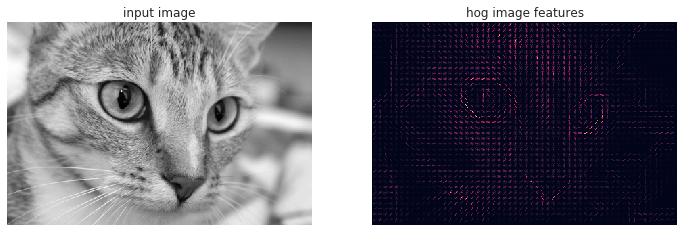

In [0]:
# import data, colour and features 
from skimage import data,color,feature
import skimage.data

# loading test image
image = color.rgb2gray(data.chelsea())

# extracting hog features 
hog_vec,hog_vis = feature.hog(image,visualise=True)

# making a subplot 
fig,ax = plt.subplots(1,2 ,figsize = (12,6), subplot_kw=dict(xticks=[],yticks=[]))

# plotting put image 
ax[0].imshow(image,cmap='gray')
ax[0].set_title('input image')

# plotting hog 
ax[1].imshow(hog_vis)
ax[1].set_title('hog image features');

# HOG:In action 

With the help of HOG features we can develop a facial detection algorithm which can be use to detect any face

## 1. Obtain a set of positive training samples 

Its time to gather some data set to process our model

In [0]:
# loading faces of people 
from sklearn.datasets import fetch_lfw_people

# loading faces of people
faces = fetch_lfw_people()

# performing positive patch
positive_patch = faces.images

# size of our positive patch
positive_patch.shape

(13233, 62, 47)

## 2. Obtain a set of negative training images 

In this section we are going to discard the section of images which are of no use to us or in simple words we are going to create a corpus of bad images to clean our training set which can be used furthur

Next we need a set of similarly sized thumbnails which do not have a face in them. One way to do this is to take any corpus of input images, and extract thumbnails from them at a variety of scales. Here we can use some of the images shipped with Scikit-Image, along with Scikit-Learn's `PatchExtractor`:

In [0]:
# importing a transform 
from skimage import data,transform

# list of imaged to use 
imgs_to_use = ['camera', 'text', 'coins', 'moon',
               'page', 'clock', 'immunohistochemistry',
               'chelsea', 'coffee', 'hubble_deep_field']
images = [color.rgb2gray(getattr(data, name)()) for name in imgs_to_use]

In [0]:
# import patch extractor 
from sklearn.feature_extraction.image import PatchExtractor

# function to extract patch 
def extract_patch(img,N,scale=1.0, patch_size = positive_patch[0].shape):
    extracted_patch_size = tuple((scale * np.array(patch_size)).astype(int))
    # making a patch extractor
    extractor = PatchExtractor(patch_size = extracted_patch_size, max_patches = N, random_state=0)
    
    #patching 
    patches = extractor.transform(img[np.newaxis])
    
    # checking for scale 
    if scale  != 1:
        patches = np.array([transform.resize(patch,patch_size) for patch in patches])
    # returning patches 
    return patches

# load negative patches 
negative_patches = np.vstack([extract_patch(im, 1000, scale) for im in images for scale in [0.5, 1.0, 2.0]])

# shape of negative patch 
negative_patches.shape

/home/sanidhya/anaconda3/lib/python3.6/site-packages/skimage/transform/_warps.py:84: UserWarning: The default mode, 'constant', will be changed to 'reflect' in skimage 0.15.
  warn("The default mode, 'constant', will be changed to 'reflect' in "


(30000, 62, 47)

Now since we got 30000 images for training purpose its time to show case some of our patches and visualize them

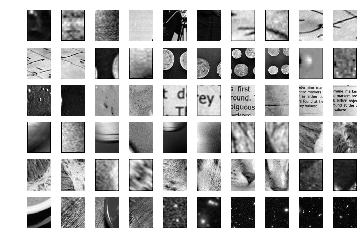

In [0]:
# making a sub plot 
fig, ax = plt.subplots(6,10)

for i, axi in enumerate(ax.flat):
    axi.imshow(negative_patches[500 * i],cmap='gray')
    axi.axis('off')

## 3. Combining sets and extract hog features 

Its time to combine images from all the negative and postive set and extract hog fetauers to make a better training set

In [0]:
# importing chain 
from itertools import chain

# making an X_train array from hog features 
X_train = np.array([feature.hog(im) for im in chain(positive_patch,negative_patches)])

# making y_train images or output 
y_train = np.zeros(X_train.shape[0])
y_train[:positive_patch.shape[0]] = 1

/home/sanidhya/anaconda3/lib/python3.6/site-packages/skimage/feature/_hog.py:119: skimage_deprecation: Default value of `block_norm`==`L1` is deprecated and will be changed to `L2-Hys` in v0.15
  'be changed to `L2-Hys` in v0.15', skimage_deprecation)


In [0]:
X_train.shape

(43233, 1215)

 Now we are left with our data in a dimesion which can be used to train our model

## 4. Time to train our Support Vector Machine

SVM's are pretty good algorithms to predict and detect image features so its time to use them though naive bayes can also be used but score is pretty less in its case.

In [0]:
# using naive bayes 
from sklearn.naive_bayes import GaussianNB
from sklearn.cross_validation import cross_val_score # to get score of k fold 

cross_val_score(GaussianNB(), X_train,y_train)

/home/sanidhya/anaconda3/lib/python3.6/site-packages/sklearn/cross_validation.py:41: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)


array([ 0.94684616,  0.91423218,  0.94073971])

Although we are getting an accuracy of around 92% this can be increased with the help of SVM's and some kernel tricks so its time to use them.

In [0]:
# importing svm 
from sklearn.svm import LinearSVC
from sklearn.grid_search import GridSearchCV # to find best params

# model tuning of our LinearSVC
grid = GridSearchCV(LinearSVC(),{'C':[1.0,2.0,4.0,8.0]}) 
# fitting grid data 
grid.fit(X_train,y_train)

# returning best score 
grid.best_score_

/home/sanidhya/anaconda3/lib/python3.6/site-packages/sklearn/grid_search.py:42: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. This module will be removed in 0.20.
  DeprecationWarning)


0.9864224088080864

In [0]:
# returning best parameter
grid.best_params_

{'C': 2.0}

Time to re-train our model on full data  

In [0]:
model = grid.best_estimator_
model.fit(X_train,y_train)

LinearSVC(C=2.0, class_weight=None, dual=True, fit_intercept=True,
     intercept_scaling=1, loss='squared_hinge', max_iter=1000,
     multi_class='ovr', penalty='l2', random_state=None, tol=0.0001,
     verbose=0)

## 5. Find faces in new image

Its time to find faces in new images since now our model is ready 

/home/sanidhya/anaconda3/lib/python3.6/site-packages/skimage/transform/_warps.py:84: UserWarning: The default mode, 'constant', will be changed to 'reflect' in skimage 0.15.
  warn("The default mode, 'constant', will be changed to 'reflect' in "


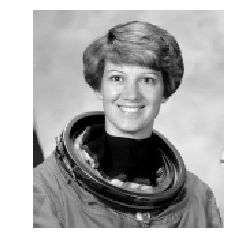

In [0]:
# test image 
test_image = data.astronaut()
test_image = color.rgb2gray(test_image) # to gray color
test_image = transform.rescale(test_image,0.5) # to reduce our test image

test_image = test_image[:160, 40:180]

# plot test image
plt.imshow(test_image,cmap='gray')
plt.axis('off');

Now its time to create a sliding window in order to get and test our face detector, this window can aslo be used to find patches

In [0]:
# function for sliding window 

def sliding_window(img, patch_size=positive_patch[0].shape,
                   istep=2, jstep=2, scale=1.0):
    Ni, Nj = (int(scale * s) for s in patch_size)
    for i in range(0, img.shape[0] - Ni, istep):
        for j in range(0, img.shape[1] - Ni, jstep):
            patch = img[i:i + Ni, j:j + Nj]
            if scale != 1:
                patch = transform.resize(patch, patch_size)
            yield (i, j), patch
            
indices, patches = zip(*sliding_window(test_image))
patches_hog = np.array([feature.hog(patch) for patch in patches])
patches_hog.shape

/home/sanidhya/anaconda3/lib/python3.6/site-packages/skimage/feature/_hog.py:119: skimage_deprecation: Default value of `block_norm`==`L1` is deprecated and will be changed to `L2-Hys` in v0.15
  'be changed to `L2-Hys` in v0.15', skimage_deprecation)


(1911, 1215)

Finally we can take this test hog to predict wether image has a face patch or not

In [0]:
labels = model.predict(patches_hog)
labels.sum()

31.0

We can see that out of 2000 patches we found approx 31 detections which is a nice sign time to draw them as a rectangle on test images:

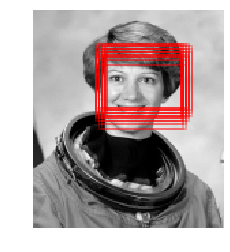

In [0]:
# creating a subplots 
fig,ax = plt.subplots()

# showing a picture
ax.imshow(test_image,cmap='gray')
ax.axis('off')

Nj,Ni = positive_patch[0].shape
indices = np.array(indices)

for i, j in indices[labels == 1]:
    ax.add_patch(plt.Rectangle((j, i), Nj, Ni, edgecolor='red',
                               alpha=0.3, lw=2, facecolor='none'))